# Projet 2
## made by: José Lucas Barretto and Lucas Miguel Celinga Agrizzi

### Question 1)

Import the dataset and sort values based on the date:

In [1]:
import pandas as pd

df = pd.read_excel('quarterly.xls', sheet_name = 'TB3MS')
df['DATE'] = pd.to_datetime(df.DATE)
df.sort_values('DATE', inplace=True)

Check for any missing dates/values in the dataset:

In [2]:
quarters = pd.date_range(start = df['DATE'][0], end = df['DATE'][len(df)-1], freq='QS')
missing_quarters = quarters.difference(df['DATE'])
print('missing quarters in the dataset? -', len(missing_quarters)!=0)
print('missing values in the dataset? -', df.isna().any().any())

missing quarters in the dataset? - False
missing values in the dataset? - False


### Question 2)

Calculate the quarterly inflation rate in %:

In [12]:
inf = df['CPI'].pct_change().dropna()*100
dates = df['DATE'][1:]

Plot the quarterly inflation rate through time:

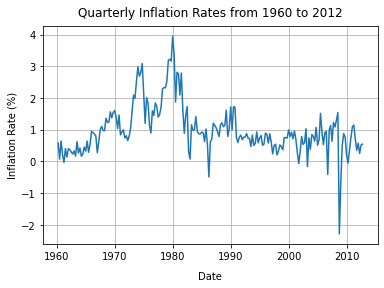

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(dates, inf)
plt.ylabel('Inflation Rate (%)')
plt.xlabel('Date', labelpad=10)
plt.title('Quarterly Inflation Rates from 1960 to 2012', pad=10)
plt.grid()
plt.show()

# MAKE COMMENTARY!!!!!!!!

### Question 3)

First, we're going to plot the autocorrelogram for *inf*. The idea here is to calculate the correlation between a time series observation and its previous values, which is called the autocorrelation. The autocorrelogram, thus, is just a plot of the autocorrelation by lag. To this end, we can use statsmodels' plot_acf function, which will also plot the region of confidence (values outside the blue region have confidence over 95%).

In our case, we want to see how the inflation rate of one quarter correlates with that of previous quarters.

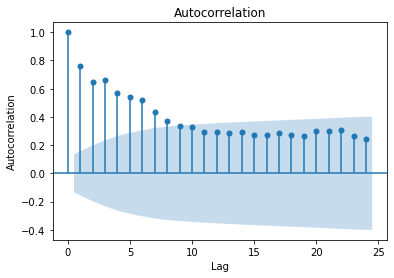

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots()
ax.set_title('Autocorrelogram for Quarterly Inflation Rates', pad=10)
ax.set_ylabel('Autocorrelation')
ax.set_xlabel('Lag')
plot_acf(inf, ax = ax)
plt.show()

We can see in the autocorrelogram above that the inflation rate of a quarter is highly correlated (> 0.5) with those of the 5 previous quarters. Also, since these autocorrelation values are outside the blue region, they have a high statistical confidence (over 95%).

Now, let's plot the partial autocorrelogram. The idea behing the partial autocorrelogram of a time series to obtain the conditional correlation between the observation at time t and the observation at time t-h (lag h), given that we observed what we observed in all timesteps between t and h. Therefore, the partial autocorrelation aims to remove the effects of the observations between the current observation and the observation at lag h, which also means that it removes indirect correlations that are included in the autocorrelogram.

Due to this property, for an AR model of order k, the partial autocorrelations are 0 for every lag beyond k. We can use this information to estimate the order of an AR model by counting the number of lags with non-zero partial autocorrelation.

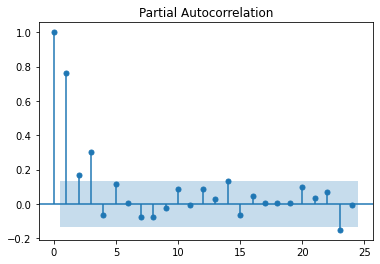

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(inf)
plt.show()

From the partial autocorrelogram above, we can see that the partial autocorrelation is statistically significant for lags up to 3 (values outside the blue region, which means confidence over 95%), which could suggest an AR model of order k=3 to predict the inflation.

### Question 4)

In time series analysis, **stationarity** means that the joint distribution for random variables at times $(Y_{s+1}, Y_{s+2}, ..., Y_{s+T})$ does not depend on $s$. This means that the distribution of the processe's variables does not vary over time. 

On the other hand, **ergodicity** means that the process does not depend on initial conditions, and that we can deduce statistical properties given sufficient random samples of a process.

If both of these conditions are satisfied, and the mean of variables is not infinite, then the temporal mean is equal to the spatial mean.

$$
E(Y_t) = \frac{1}{T} \sum_{t=1}^{T}Y_t \rightarrow \mu
$$

A **spurious regression** is a problem that happens when a regression shows evidence of a non-existing relationship between two variables. This means that the regression coefficient estimate should be zero (because the two variables are uncorrelated), but the regression returns a statistically significant value that is not zero, but has a high $R^2$ value (generalizes very badly). This can happen, if the time series are random walks, which are non-stationary .

### Question 5)

lags: 1 - AIC: -1.3546907748283459 - BIC: -1.3068749529609534
lags: 2 - AIC: -1.3771598479087657 - BIC: -1.3131917282539367
lags: 3 - AIC: -1.457867594311414 - BIC: -1.3776383135493633
lags: 4 - AIC: -1.451937606983782 - BIC: -1.3553370622514525
lags: 5 - AIC: -1.4533109129135484 - BIC: -1.3402277421294364
lags: 6 - AIC: -1.4384124181490383 - BIC: -1.308733979938759
lag value with lowest AIC: 3


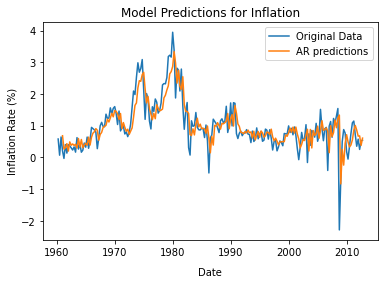

In [46]:
import warnings
from statsmodels.tsa.api import AutoReg

warnings.filterwarnings('ignore')

results = {}
for lag in range(1,7):
    model = AutoReg(inf, lags=lag).fit()
    results[lag] = [model.aic, model.bic]
    print('lags:', lag, '- AIC:', model.aic, '- BIC:', model.bic)

best_lag = min(results, key = lambda k: results[k][0])
print('lag value with lowest AIC:', best_lag)

model = AutoReg(inf, lags=best_lag).fit()
predictions = model.predict(dynamic=False)

plt.figure()
plt.title('Model Predictions for Inflation')
plt.ylabel('Inflation Rate (%)')
plt.xlabel('Date', labelpad=10)
plt.plot(dates, inf, dates, predictions)
plt.legend(['Original Data', 'AR predictions'])
plt.show()

In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                    CPI   No. Observations:                  211
Model:                     AutoReg(1)   Log Likelihood                -152.735
Method:               Conditional MLE   S.D. of innovations              0.501
Date:                Wed, 18 Nov 2020   AIC                             -1.355
Time:                        19:10:10   BIC                             -1.307
Sample:                             1   HQIC                            -1.335
                                  211                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2342      0.056      4.182      0.000       0.124       0.344
CPI.L1         0.7626      0.045     17.079      0.000       0.675       0.850
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3113           +0.0000j            1.3113            0.0000
-----------------------------------------------------------------------------
"""